In [1]:
import os
print(os.getcwd())
def update_working_directory():
    from pathlib import Path
    p = Path(os.getcwd()).parents[0]
    os.chdir(p)
    print(p)
update_working_directory()

/Users/admin/Projects/doggo/notebooks
/Users/admin/Projects/doggo


# Importing the required libraries

In [2]:
import numpy as np
import pandas as pd
import gym
import time
import math
from tqdm import tqdm
import random
from collections import defaultdict

# Building the environment

## Reset

In [3]:
decimals_state = 3
def get_state_id(dog_state):
    return '{:01.4f}_{:01.4f}_{:01.4f}'.format(dog_state['food'], dog_state['fat'], dog_state['affection'])

In [4]:
def env_reset():
    
    dog_state = {
        'food': 0.5,
        'fat': 0,
        'affection': 0.5
        }
    
    dog_state['state_id'] = get_state_id(dog_state)
    
    return dog_state

## Observation and action spaces

In [5]:
# n_states = env.observation_space.n
# n_states = 11*11*11
# n_actions = env.action_space.n
n_actions= 4

## Next state

In [6]:
WALKING_TIME = 0
EATING_TIME = 0
PLAYING_TIME = 0

food_consumption_rate = 1.0 / (30 * 3600)
affection_consumption_rate = 1.0 / (50 * 3600)
walking_fat_converge_rate = 0.2
walking_affection_converge_rate = 0.4
playing_fat_converge_rate = 0.1
playing_affection_converge_rate = 0.20
eating_food_increase = 0.6
eating_fat_increase = 0.25

In [7]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

In [8]:
def apply_decreasing_rate(value: float, rate: float) -> float:
    """
    Apply a decreasing rate to a value
    :param value: current value
    :param rate: per second
    :return: updated value
    """
    return value - (60 * rate)

def converge(value: float, target: float, ratio: float) -> float:
    diff: float = (target - value) * ratio
    return value + diff


def update_food(dog_state):
    update_food = apply_decreasing_rate(dog_state['food'], food_consumption_rate)
    return round_down(max(0.0, update_food), decimals=decimals_state)

def update_fat(dog_state):
    update_fat = dog_state['fat']
    return update_fat

def update_affection(dog_state):
    update_affection = apply_decreasing_rate(dog_state['affection'], affection_consumption_rate)
    return round_down(max(0.0, update_affection), decimals=decimals_state)


def update_if_walking(dog_state):
    update_fat = round_down(converge(dog_state['fat'], 0.0, walking_fat_converge_rate), decimals=decimals_state)
    update_affection = round_up(converge(dog_state['affection'], 1.0, walking_affection_converge_rate), decimals=decimals_state)
    return (update_fat, update_affection)

def update_if_feeding(dog_state):
    update_food = round_up(min(dog_state['food'] + eating_food_increase, 1.0), decimals=decimals_state)
    update_fat = round_up(min(dog_state['fat'] + eating_fat_increase, 1.0), decimals=decimals_state)
    return (update_food, update_fat)

def update_if_playing(dog_state):
    update_fat = round_down(converge(dog_state['fat'], 0.0, playing_fat_converge_rate), decimals=decimals_state)
    update_affection = round_up(converge(dog_state['affection'], 1.0, playing_affection_converge_rate), decimals=decimals_state)
    return (update_fat, update_affection)


def update_done(dog_state):
    happiness = min(dog_state['food'], 1.0 - dog_state['fat'], dog_state['affection'])
    return happiness <= 0.0

In [9]:
# state2, reward1, done, info = env.step(action1)
def env_step(state1, action):
    
    state2 = state1.copy()
    
    # Affect of time
    state2['food'] = update_food(state2)
    state2['fat'] = update_fat(state2)
    state2['affection'] = update_affection(state2)

    # Affect of actions
    if action == 1: # WALKING
        state2['fat'], state2['affection'] = update_if_walking(state2)

    if action == 2: # FEEDING
        state2['food'], state2['fat'] = update_if_feeding(state2)

    if action == 3: # PLAYING
        state2['fat'], state2['affection'] = update_if_playing(state2)

    reward = min(state2['food'], 1.0 - state2['fat'], state2['affection'])
    done = update_done(state2)
    
    info = None
    
    state2['state_id'] = get_state_id(state2)
    
    return (state2, reward, done, info)

## Render

In [10]:
def env_render(dog_state, action, Q):
    print(dog_state)
    print(action)
    print(Q[dog_state['state_id']])

# Defining utility functions to be used in the learning process

## Initialising Q

In [11]:
def init_Q(n_actions, init_Q_type="ones"):
    """
    @param n_actions the number of actions
    @param type random, ones or zeros for the initialization
    """
    if init_Q_type == "ones":
        default_Q_values = np.ones(n_actions)
    elif init_Q_type == "random":
        default_Q_values = np.random.random(n_actions)
    elif init_Q_type == "zeros":
        default_Q_values = np.zeros(n_actions)
    
    def get_default_Q_values():
        return default_Q_values

    return defaultdict(get_default_Q_values)

## Choose an action

In [12]:
# Numpy generator
rng = np.random.default_rng()  # Create a default Generator.

In [13]:
def epsilon_greedy(Q, state_id, n_actions, epsilon):
    """
    @param Q Q values {state, action} -> value
    @param epsilon for exploration
    @param n_actions number of actions
    @param state state at time t
    """
    if rng.uniform(0, 1) < epsilon:
        action = np.random.randint(0, n_actions)
    else:
        winner = np.argwhere(Q[state_id] == np.amax(Q[state_id]))
        winner_list = winner.flatten().tolist()
        action = random.choice(winner_list)
    
    return action

## Update Q-matrice (state-action value function)

In [14]:
# Function to learn the Q-value  - Is it temporal-difference?
def update(state1_id, action1, reward1, state2_id, action2, expected=False):
    
    previous_Q_value_state1 = Q[state1_id].copy()
    
    predict = Q[state1_id][action1] 
    
    target = reward1 + gamma * Q[state2_id][action2] 
    if expected:
        expected_value = np.mean(Q[state2_id])
        target = reward1 + gamma * expected_value
    
    new_Q_value = Q[state1_id][action1] + alpha * (target - predict)
    previous_Q_value_state1[action1] = new_Q_value
    
    Q[state1_id] = previous_Q_value_state1
        
    return Q

## Updating parameters

### Epsilon $\epsilon$ - Exploration rate

In [15]:
# Exploration rate

def get_epsilon(episode, init_epsilon, divisor=25):
    
    n_epsilon = init_epsilon/(episode/10+1)
    # n_epsilon = min(1, 1.0 - math.log10((episode + 1) / divisor))
    
    return n_epsilon

### Alpha $\alpha$ - Learning rate

In [16]:
# Learning rate

def get_alpha(episode, init_alpha, divisor=25):
    
    n_alpha = init_alpha/(episode/1000+1)
    # n_alpha = min(1.0, 1.0 - math.log10((episode + 1) / divisor))
    
    return n_alpha

## Plots Reward / Steps

In [17]:
import numpy as np
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution_reward(evolution_reward):
    
    n_moving_points = int(np.ceil(len(evolution_reward)/100))
    y = running_mean(evolution_reward,n_moving_points)
    x = range(len(y))

    plt.plot(x, y)
    plt.title('Evolution of Reward over time (smoothed over window size 100)')
    plt.xlabel('Episode') # will add a label “Year” to your x-axis
    plt.ylabel('Episode Reward (Smoothed)') # will add a label “Population” to your y-axis
    plt.xticks() # set the numbers on the x-axis to be 1, 2, 3, 4, 5. We can also pass and labels as a second argument. For, example, if we use this code plt.xticks([1, 2, 3, 4, 5], ["1M", "2M", "3M", "4M", "5M"]), it will set the labels 1M, 2M, 3M, 4M, 5M on the x-axis.
    plt.yticks() # - works the same as plt.xticks(), but for the y-axis.
    plt.grid(True)
    plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution_steps(evolution_steps):
    
    n_moving_points = int(np.ceil(len(evolution_steps)/100))
    y = running_mean(evolution_steps,n_moving_points)
    x = range(len(y))

    plt.plot(x, y)
    plt.title('Episode length over time (smoothed over window size 100)')
    plt.xlabel('Episode') # will add a label “Year” to your x-axis
    plt.ylabel('Episode Length (Smoothed)') # will add a label “Population” to your y-axis
    plt.xticks() # set the numbers on the x-axis to be 1, 2, 3, 4, 5. We can also pass and labels as a second argument. For, example, if we use this code plt.xticks([1, 2, 3, 4, 5], ["1M", "2M", "3M", "4M", "5M"]), it will set the labels 1M, 2M, 3M, 4M, 5M on the x-axis.
    plt.yticks() # - works the same as plt.xticks(), but for the y-axis.
    plt.grid(True)
    plt.show()

# Initializing different parameters

In [20]:
# Defining the different parameters 
init_epsilon = 1 # trade-off exploration/exploitation - better if decreasing
init_alpha = 0.5 # learning rate, better if decreasing

# Specific to environment
gamma = 0.95 # discount for future rewards (also called decay factor)
# n_states = env.observation_space.n # useless
n_actions = 4

# Episodes
n_episodes = 10000
nmax_steps = 60*24*365 # maximum steps per episode

# Initializing the Q-matrix 
Q = init_Q(n_actions, init_Q_type="zeros")

# Training the learning agent

In [21]:
# Visualisation
(render_episode, render_training) = (False, False)

In [22]:
# Initializing the reward
evolution_reward = []
evolution_steps = []
evolution_happiness_all = []

  1%|          | 87/10000 [00:00<00:22, 438.43it/s]

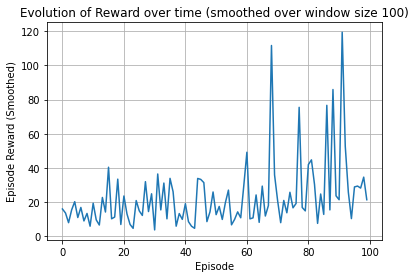

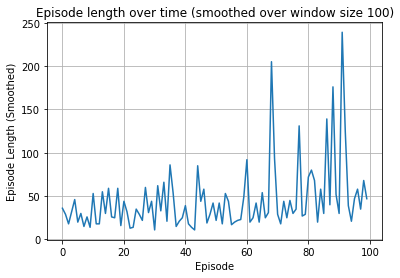

  2%|▏         | 181/10000 [00:01<01:03, 155.40it/s]

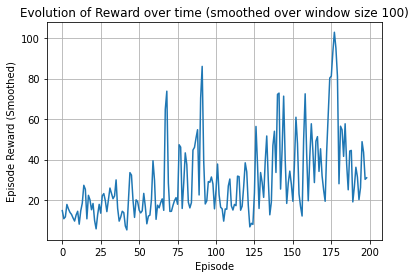

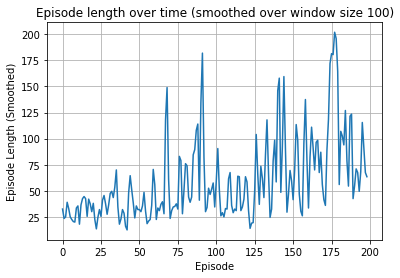

  3%|▎         | 296/10000 [00:02<01:22, 117.38it/s]

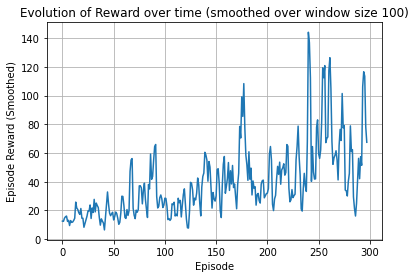

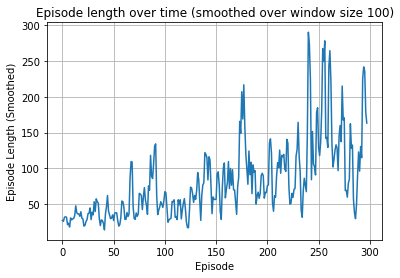

  4%|▍         | 398/10000 [00:04<02:41, 59.56it/s] 

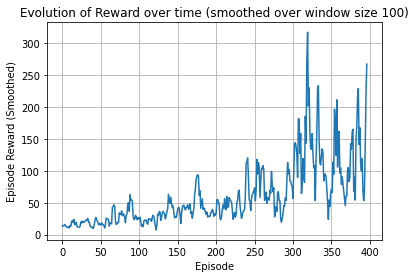

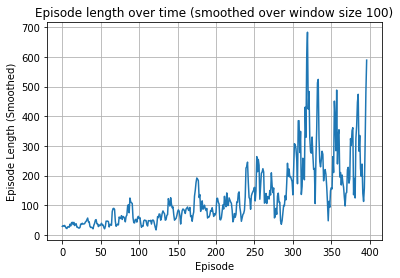

  5%|▍         | 499/10000 [00:07<03:39, 43.29it/s]

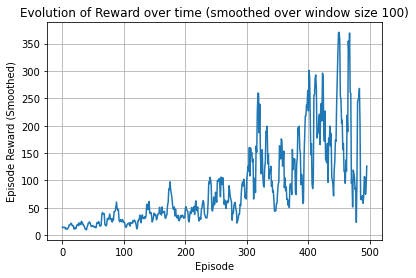

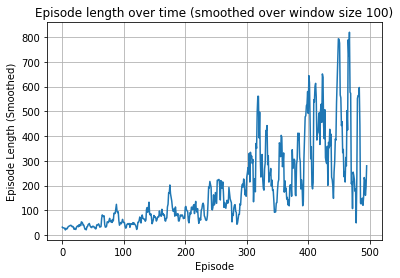

  6%|▌         | 596/10000 [00:10<05:05, 30.77it/s]

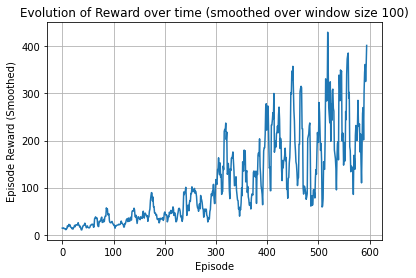

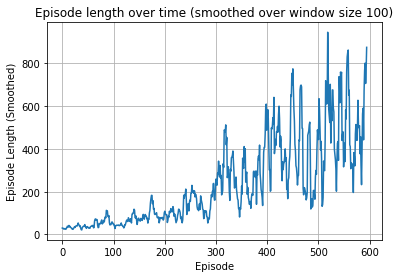

  7%|▋         | 696/10000 [00:16<11:04, 14.01it/s]

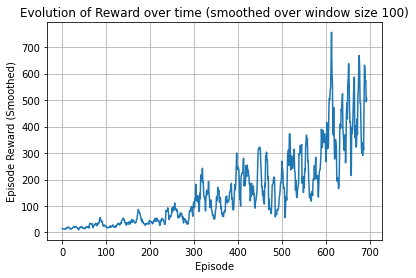

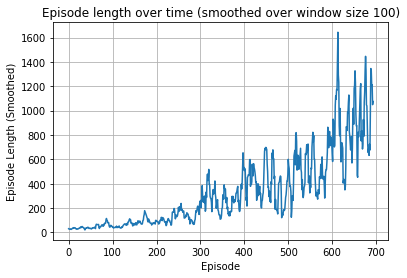

  8%|▊         | 796/10000 [00:22<09:10, 16.73it/s]

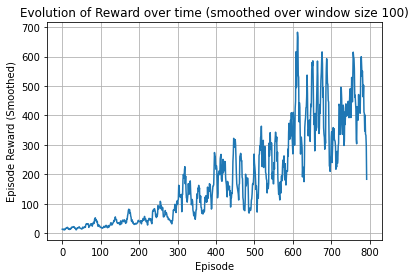

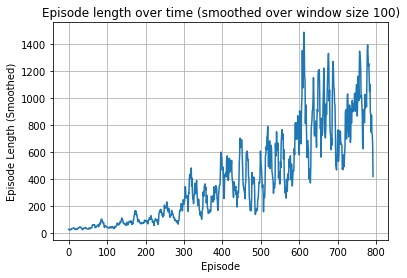

  9%|▉         | 899/10000 [00:30<11:57, 12.68it/s]

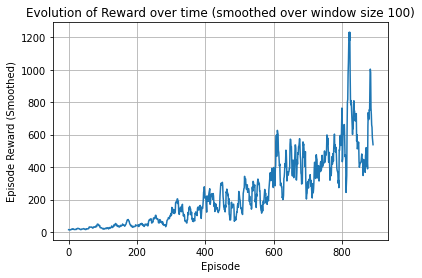

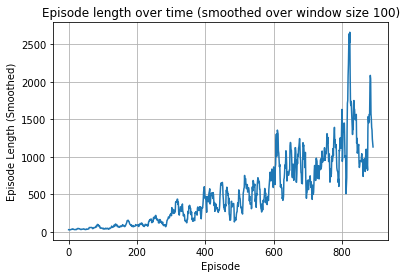

 10%|▉         | 998/10000 [00:38<15:43,  9.54it/s]

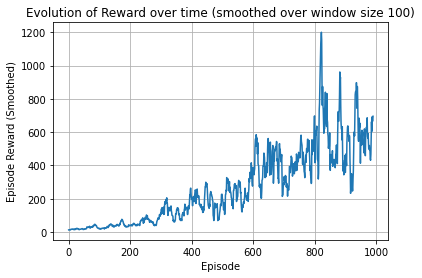

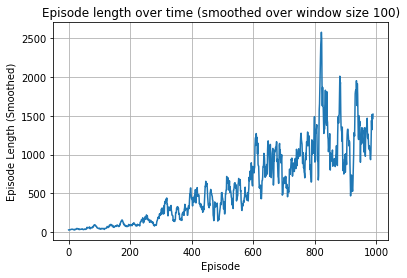

 11%|█         | 1099/10000 [00:47<15:12,  9.75it/s]

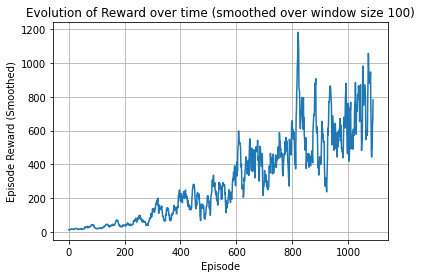

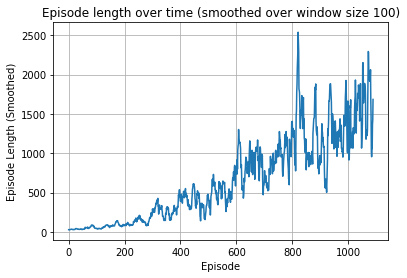

 12%|█▏        | 1197/10000 [01:04<33:25,  4.39it/s]  

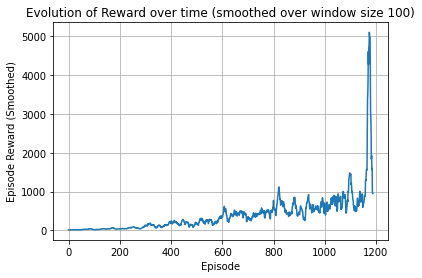

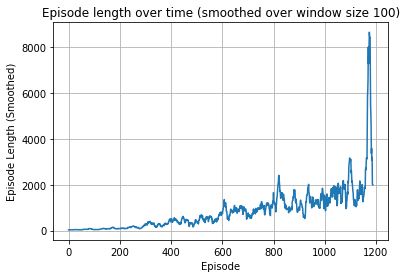

 13%|█▎        | 1299/10000 [01:46<1:12:52,  1.99it/s]

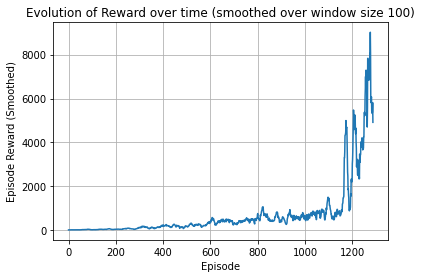

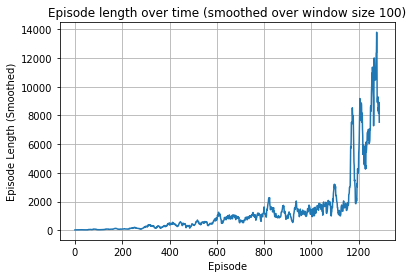

 14%|█▍        | 1398/10000 [02:30<48:16,  2.97it/s]  

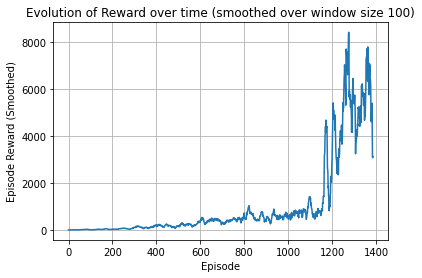

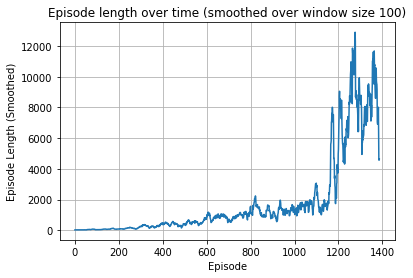

 15%|█▍        | 1497/10000 [03:16<30:01,  4.72it/s]  

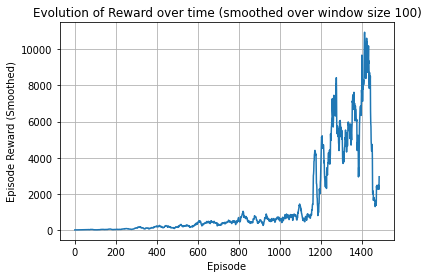

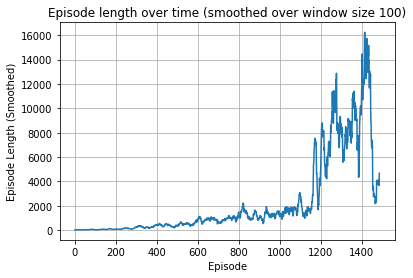

 16%|█▌        | 1599/10000 [03:56<1:08:18,  2.05it/s]

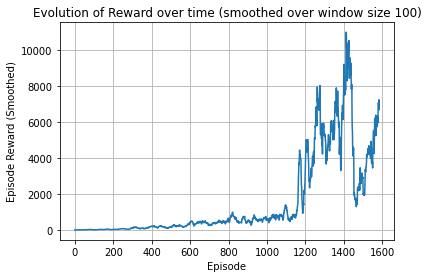

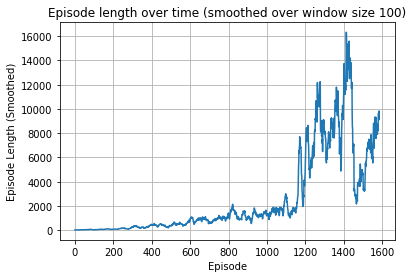

 17%|█▋        | 1699/10000 [05:36<1:56:02,  1.19it/s]

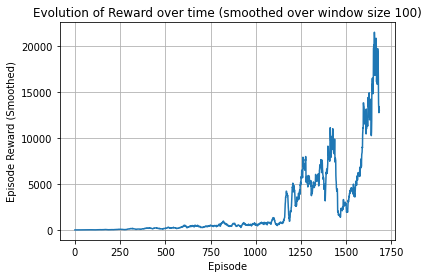

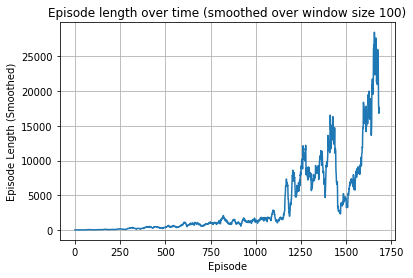

 18%|█▊        | 1799/10000 [07:13<3:07:15,  1.37s/it]

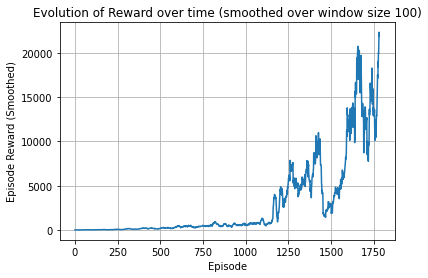

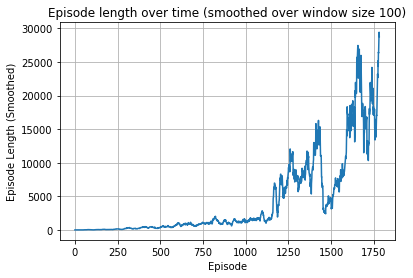

 19%|█▉        | 1898/10000 [09:12<1:52:51,  1.20it/s]

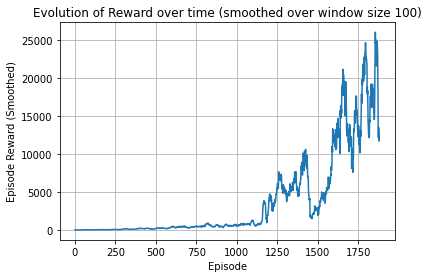

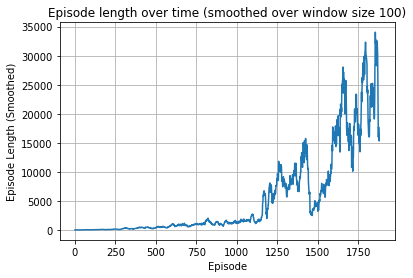

 20%|█▉        | 1999/10000 [11:12<2:24:22,  1.08s/it]

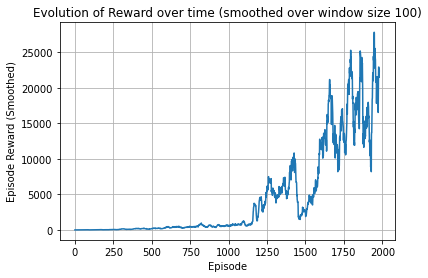

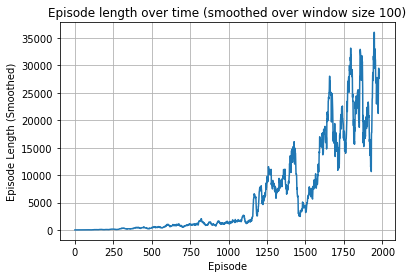

 21%|██        | 2099/10000 [13:56<2:41:39,  1.23s/it]

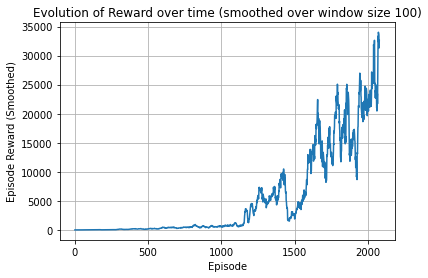

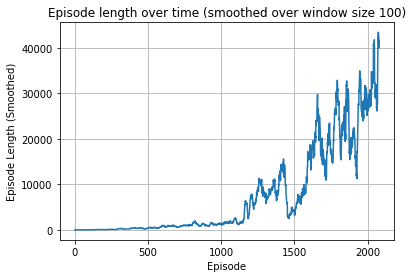

 22%|██▏       | 2199/10000 [17:48<15:00:32,  6.93s/it]

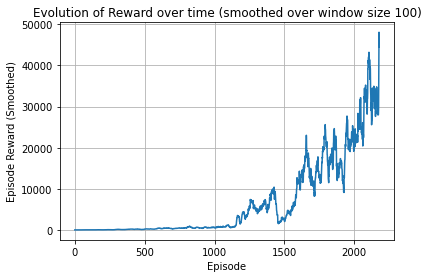

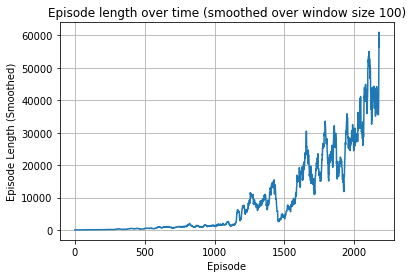

 23%|██▎       | 2299/10000 [21:04<4:49:41,  2.26s/it] 

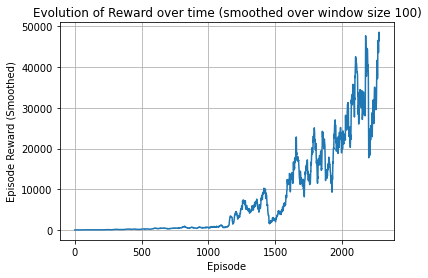

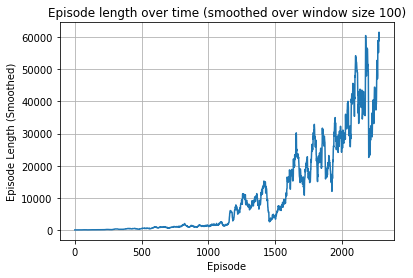

 24%|██▍       | 2399/10000 [25:23<7:03:47,  3.35s/it] 

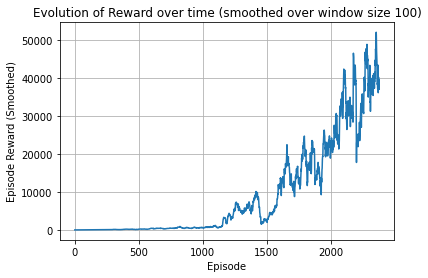

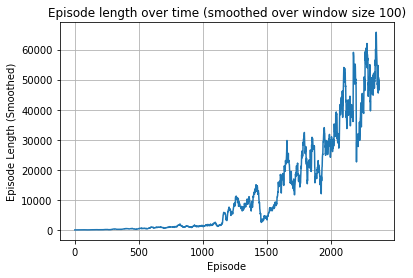

 25%|██▍       | 2499/10000 [30:28<6:10:14,  2.96s/it] 

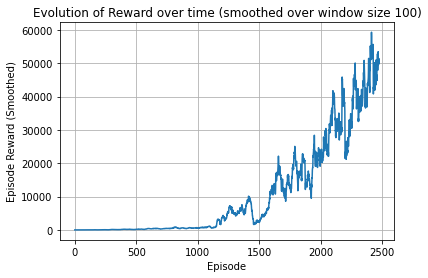

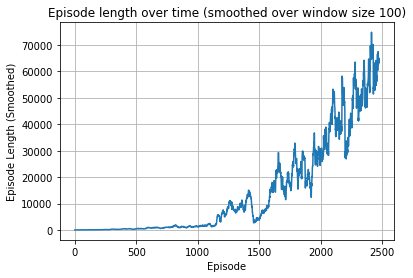

 26%|██▌       | 2599/10000 [35:54<2:57:12,  1.44s/it] 

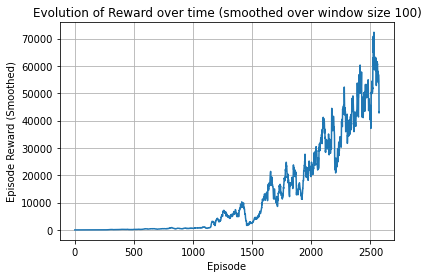

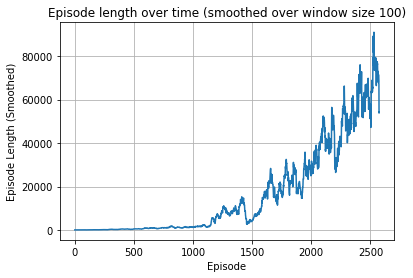

 27%|██▋       | 2699/10000 [42:12<9:12:44,  4.54s/it] 

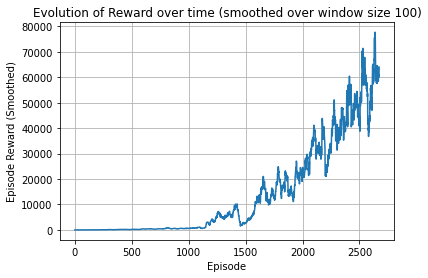

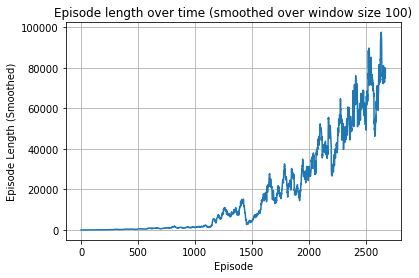

 28%|██▊       | 2799/10000 [50:00<18:28:18,  9.23s/it]

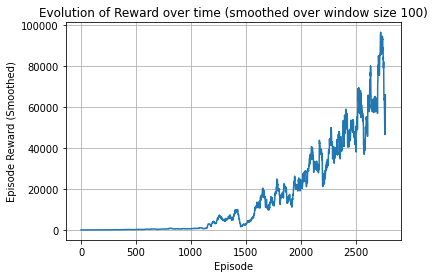

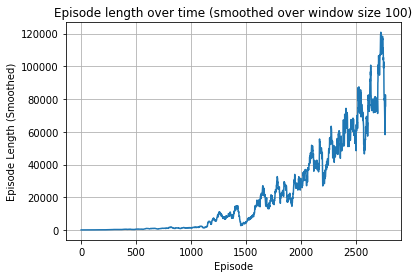

 29%|██▉       | 2899/10000 [56:31<5:37:14,  2.85s/it] 

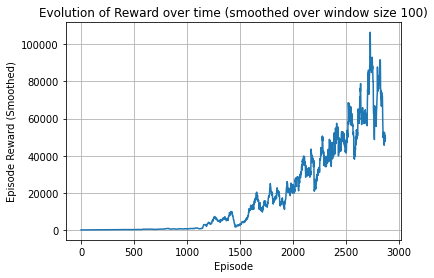

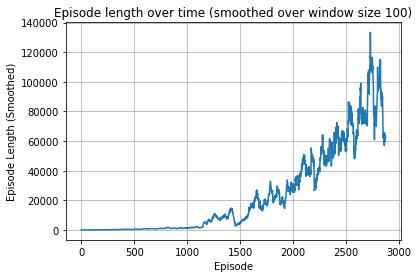

 30%|██▉       | 2999/10000 [1:03:54<7:37:03,  3.92s/it] 

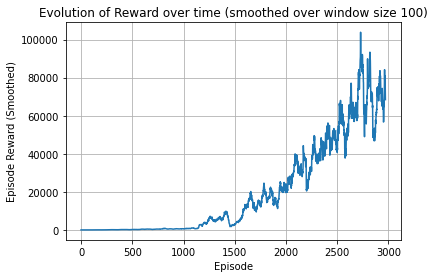

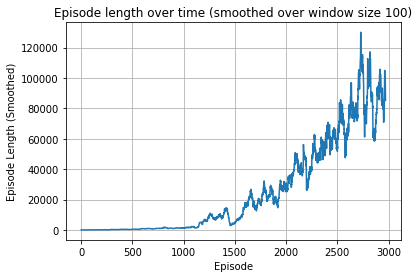

 31%|███       | 3099/10000 [1:14:32<9:21:07,  4.88s/it] 

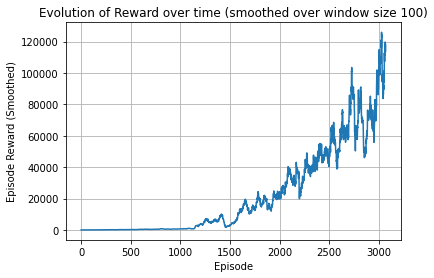

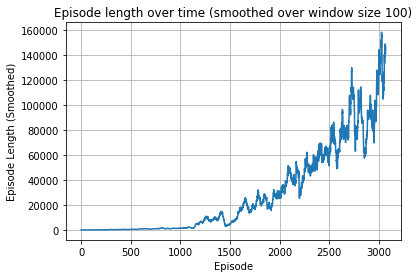

 32%|███▏      | 3199/10000 [1:25:17<11:42:54,  6.20s/it]

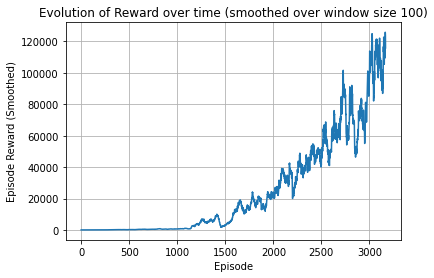

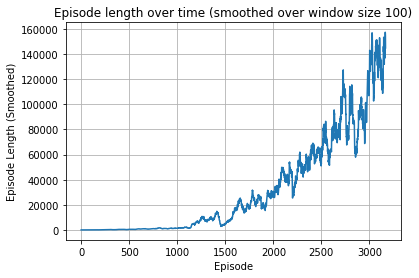

 33%|███▎      | 3299/10000 [1:39:42<6:53:32,  3.70s/it] 

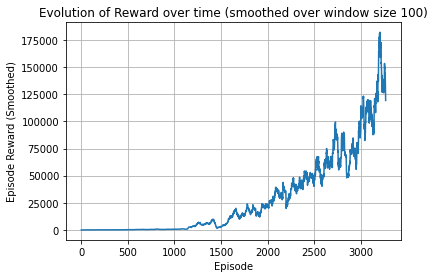

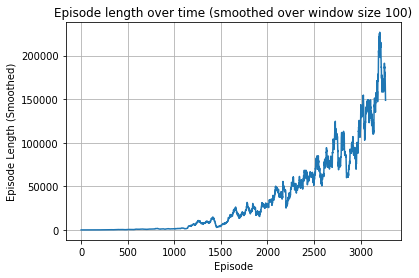

 34%|███▍      | 3398/10000 [1:44:56<2:39:55,  1.45s/it] 

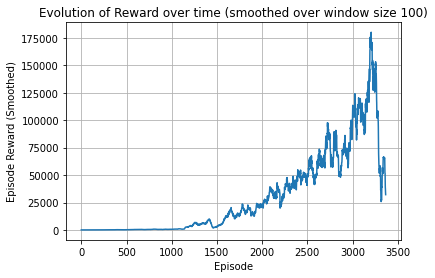

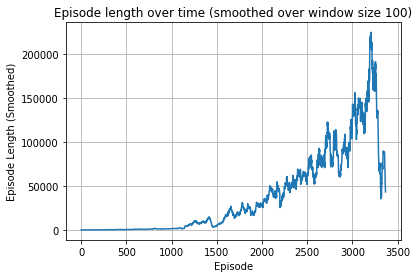

 35%|███▍      | 3499/10000 [1:54:10<11:39:52,  6.46s/it]

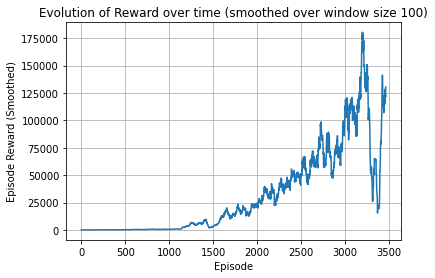

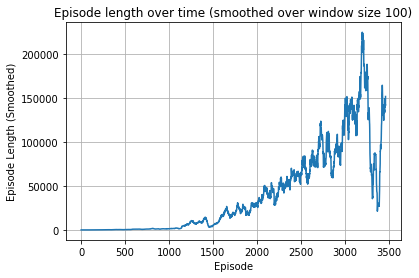

 36%|███▌      | 3599/10000 [2:11:45<14:31:08,  8.17s/it]

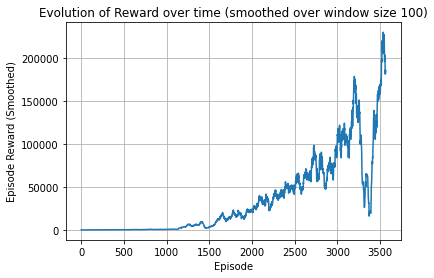

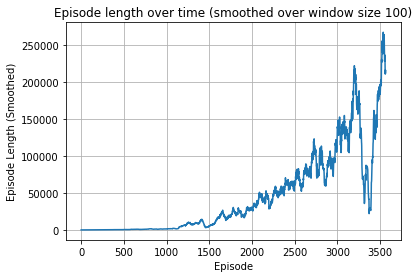

 37%|███▋      | 3699/10000 [2:28:10<16:08:30,  9.22s/it]

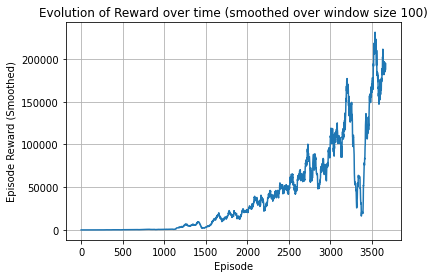

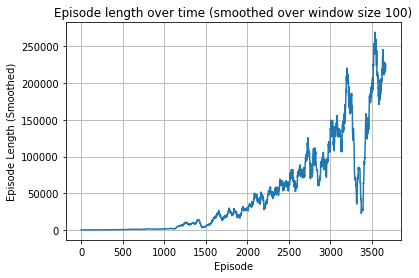

 38%|███▊      | 3799/10000 [2:45:10<22:31:00, 13.07s/it]

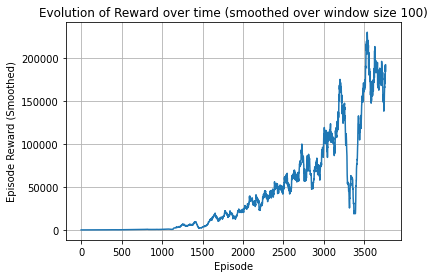

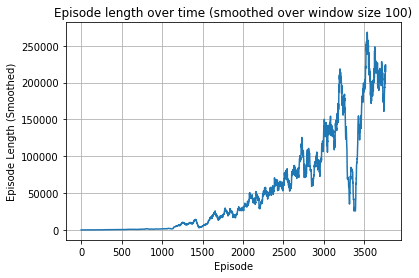

 39%|███▉      | 3899/10000 [3:03:25<16:56:36, 10.00s/it]

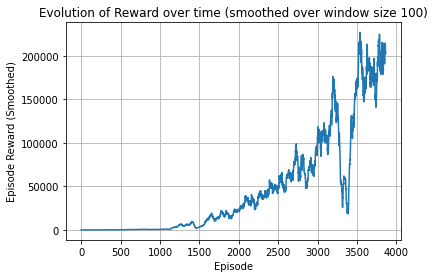

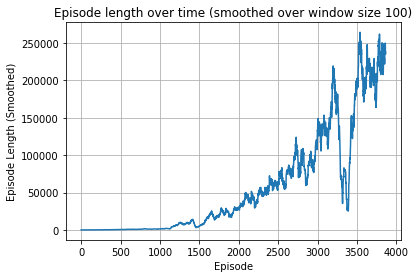

 40%|███▉      | 3999/10000 [3:23:31<12:41:58,  7.62s/it]

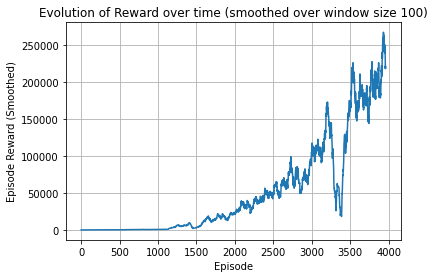

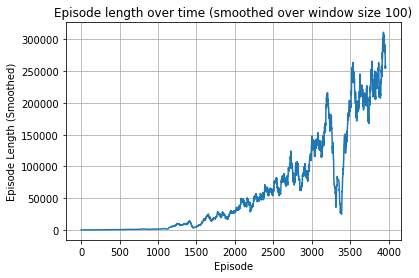

 41%|████      | 4099/10000 [3:45:06<21:12:12, 12.94s/it]

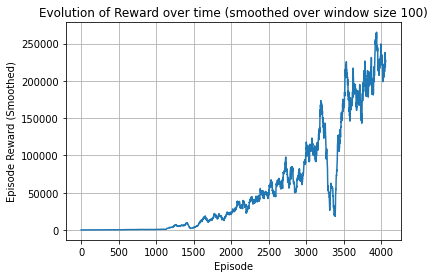

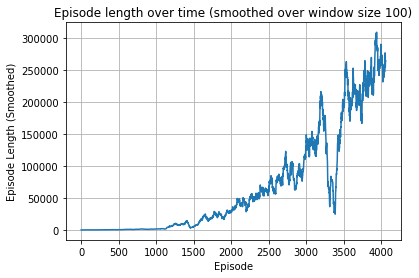

 42%|████▏     | 4199/10000 [4:07:28<14:43:51,  9.14s/it]

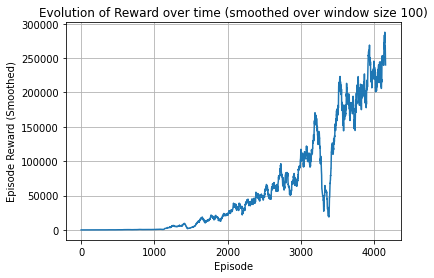

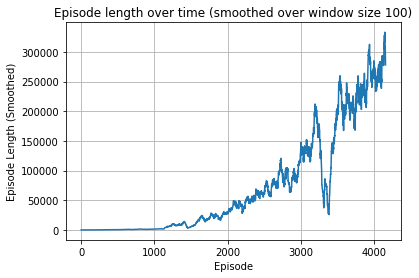

 43%|████▎     | 4299/10000 [4:32:14<16:59:37, 10.73s/it]

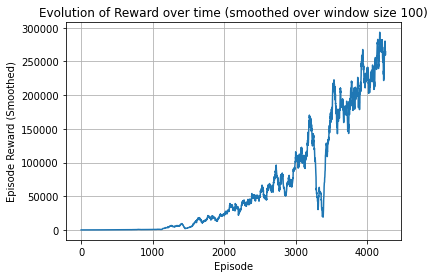

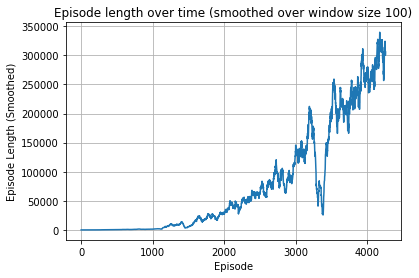

 44%|████▍     | 4399/10000 [4:53:45<15:00:31,  9.65s/it]

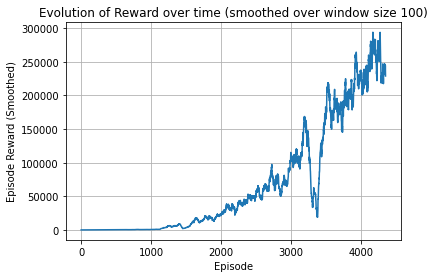

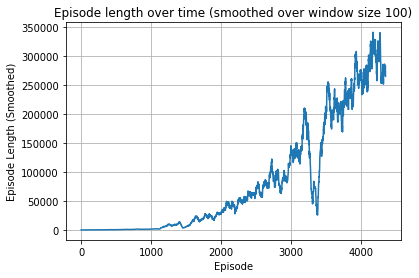

 45%|████▍     | 4499/10000 [5:17:50<24:59:45, 16.36s/it]

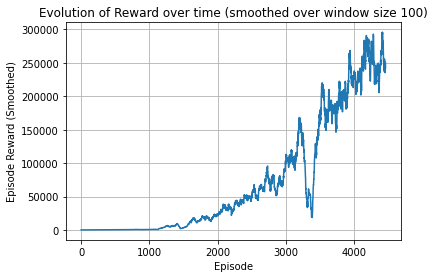

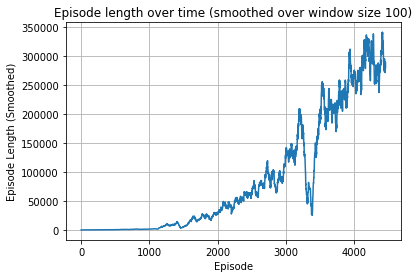

 46%|████▌     | 4599/10000 [5:43:58<26:34:05, 17.71s/it]

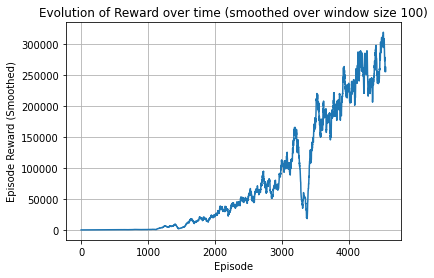

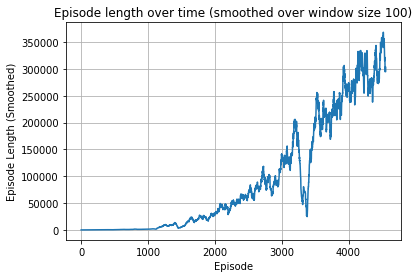

 47%|████▋     | 4699/10000 [6:10:47<24:27:28, 16.61s/it]

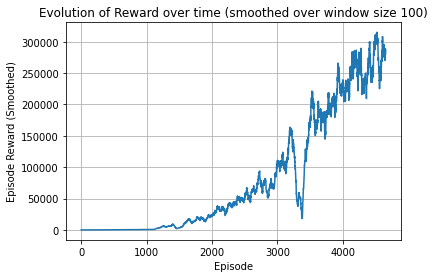

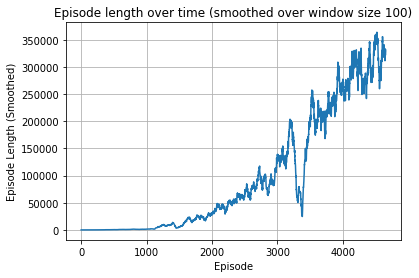

 48%|████▊     | 4799/10000 [7:40:08<49:59:24, 34.60s/it]   

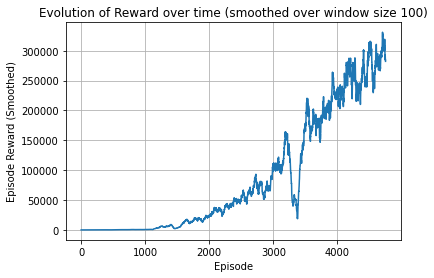

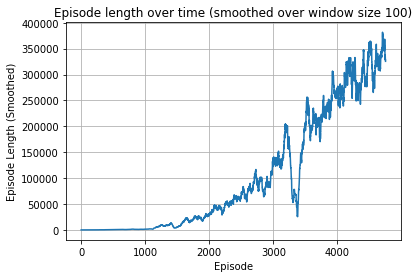

 49%|████▉     | 4899/10000 [8:33:34<38:31:26, 27.19s/it]

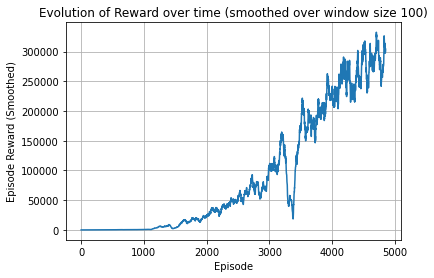

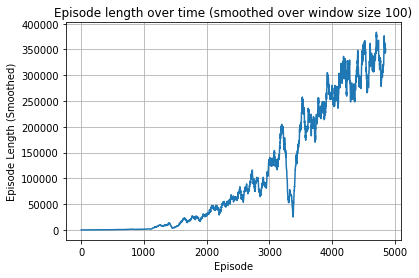

 50%|████▉     | 4999/10000 [9:33:38<39:07:56, 28.17s/it]

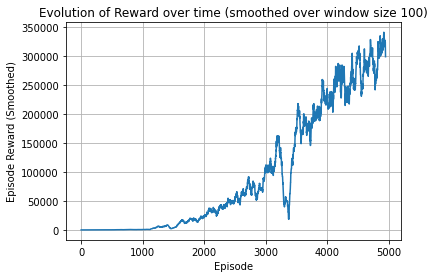

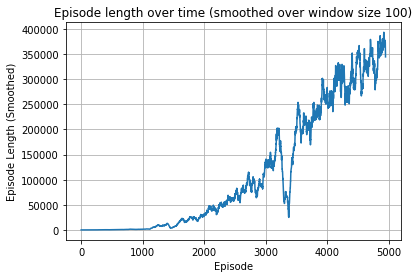

 51%|█████     | 5099/10000 [10:34:14<55:01:09, 40.41s/it]

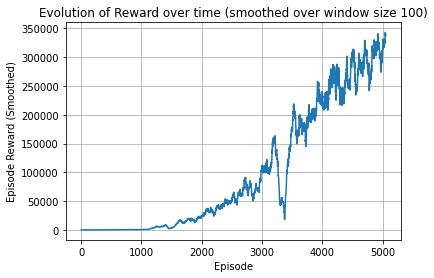

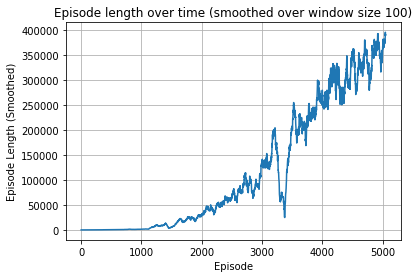

 52%|█████▏    | 5199/10000 [11:30:53<22:14:37, 16.68s/it]

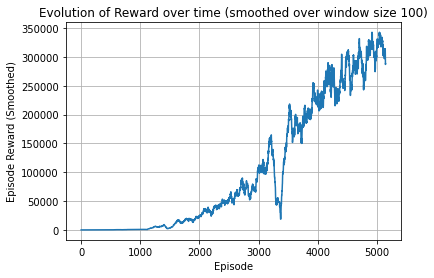

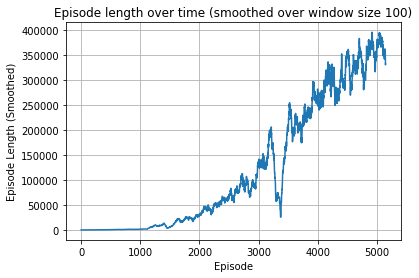

 53%|█████▎    | 5299/10000 [12:36:12<36:50:33, 28.21s/it]  

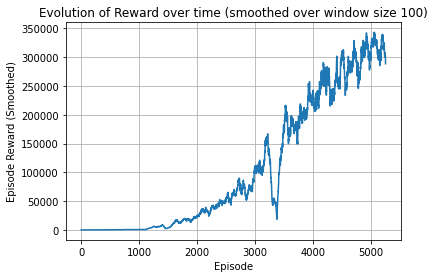

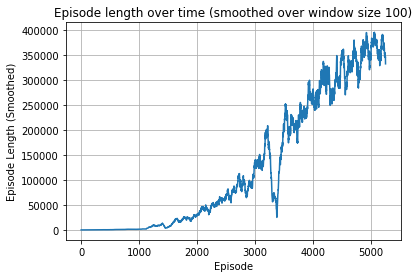

 53%|█████▎    | 5323/10000 [12:50:12<48:46:54, 37.55s/it]

In [ ]:
# Starting the SARSA learning 
for episode in tqdm(range(n_episodes)):
    
    n_episode_steps = 0
    episode_reward = 0
    evolution_happiness = [0.5]
    done = False
    
    state1 = env_reset()
    action1 = epsilon_greedy(Q, state1['state_id'], n_actions, init_epsilon)
    
    while (not done) and (n_episode_steps < nmax_steps):
    
        # Update parameters
        epsilon = get_epsilon(episode, init_epsilon)
        alpha = get_alpha(episode, init_alpha)
    
        # Visualizing the training
        if render_training:
            env_render(state1, action1, Q)
    
        # Getting the next state 
        state2, reward1, done, info = env_step(state1, action1)
        episode_reward += reward1
        evolution_happiness.append(reward1)
    
        # Choosing the next action
        action2 = epsilon_greedy(Q, state2['state_id'], n_actions, epsilon)

        # Learning the Q-value
        Q = update(state1['state_id'], action1, reward1, state2['state_id'], action2)

        # Updating the respective values 
        state1 = state2 
        action1 = action2
        n_episode_steps += 1
        
    # At the end of learning process 
    if render_episode:
        print('Episode {0}, Score: {1}, Timesteps: {2}, Epsilon: {3}, Alpha: {4}'.format(
            episode+1, episode_reward, n_episode_steps, epsilon, alpha))
    
    evolution_reward.append(episode_reward)
    evolution_steps.append(n_episode_steps)
    evolution_happiness_all.append(evolution_happiness)
    
    if ((episode+1) % 100 == 0):
        plot_evolution_reward(evolution_reward)
        plot_evolution_steps(evolution_steps)

In [ ]:
pct_state_visited = len(Q)/(11*11*11)*100
print(pct_state_visited)

In [ ]:
Q

# Evaluating the performance

## Mean reward

In [ ]:
# Evaluating the performance 
print ("Performance : ", sum(evolution_reward)/n_episodes) 

## Evolution of Reward overtime

In [ ]:
plot_evolution_reward(evolution_reward)

In [ ]:
plot_evolution_steps(evolution_steps)

## Evaluation through episode

### One

In [ ]:
# Variables
nmax_steps = 20000

n_episode_steps = 0
episode_reward = 0
done = False

# Start episode and get initial observation
state = env_reset()

while (not done) and (n_episode_steps < nmax_steps):

    # Get an action (0:Left, 1:Down, 2:Right, 3:Up)

    winner = np.argwhere(Q[state['state_id']] == np.amax(Q[state['state_id']]))
    winner_list = winner.flatten().tolist()
    action = random.choice(winner_list)

    # Perform a step
    state, reward, done, info = env_step(state, action)

    # Update score
    episode_reward += reward
    n_episode_steps += 1

print('Test Episode, Score: {0}, Timesteps: {1}'.format(
    episode_reward, n_episode_steps))


In [ ]:
Q

In [ ]:
np.random.randint(0, n_actions)

In [ ]:
episode = 10000
n_epsilon = init_epsilon/(episode/10000+1)
n_epsilon

### Multiple

In [ ]:
# Variables
episodes = 10
nmax_steps = 200
total_reward = 0

In [ ]:
# Loop episodes
for episode in range(episodes):

    n_episode_steps = 0
    episode_reward = 0
    done = False
    
    # Start episode and get initial observation
    state = env_reset()
    
    while (not done) and (n_episode_steps < nmax_steps):

        # Get an action (0:Left, 1:Down, 2:Right, 3:Up)
        
        action = np.argmax(Q[state['state_id']])
                             
        # Perform a step
        state, reward, done, info = env_step(state, action)

        # Update score
        episode_reward += reward
        total_reward += reward

        n_episode_steps += 1
        
    print('Episode {0}, Score: {1}, Timesteps: {2}'.format(
        episode+1, episode_reward, n_episode_steps))

# Print the score
print('--- Evaluation ---')
print ('Score: {0} / {1}'.format(total_reward, episodes))
print()